# compute spectra on mitgcm outputs

https://github.com/pydata/xarray/pull/924

https://github.com/pydata/xarray/issues/1603



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.220:8786 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 31 Cores: 434 Memory: 3100.00 GB


--- 

# load data

In [2]:
v = 'Eta'

## open files, binary files
#data_dir = root_data_dir+v+'/'
#iters, time = get_iters_time(v, data_dir, delta_t=25.)
#ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'

# dir where spectra are stored
E_dir = '/home/datawork-lops-osi/aponte/mit_spec/'

In [7]:
face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc')
#grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc', chunks={'i':10, 'j':432})
#grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc', chunks={'i':10, 'j':432}, decode_coords=True)
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 24
Number of files processed: 24
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [7]:
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

#ds = ds.isel(time=slice(0,3000))

#ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 928 ms, sys: 116 ms, total: 1.04 s
Wall time: 1.06 s
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 3000)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 3000), chunksize=(10, 432, 240)>

 data size: 223.9 GB


In [8]:
#chunks={'time': len(ds['time']), 'face':1,  'i': 100, 'j': 100}
#chunks={'time': len(ds['time']), 'i': 10, 'j': 432}
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 192 ms, sys: 8 ms, total: 200 ms
Wall time: 202 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 3000)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 3000), chunksize=(10, 432, 3000)>


In [9]:
#%time eta = ds['Eta'].isel(face=1).persist()
%time eta = ds['Eta'].persist()
#%time eta = ds['Eta']

CPU times: user 15.7 s, sys: 212 ms, total: 15.9 s
Wall time: 16 s


---
# zonally averaged

store spectra first

In [10]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
E = E.astype('f8').rename('E_eta')
E = xr.merge([E, grid])
#E = E.drop(['XG','YG'])
print(E)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


<xarray.Dataset>
Dimensions:            (freq_time: 3000, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k                  (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k_u                (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_l                (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_p1               (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    face               int64 1
    XC                 (i, j) float32 ...
    YC         

In [ ]:
file_E = scratch+'/mit_spec/E.nc'
E.to_netcdf(file_E,mode='w')
# should transpose?

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 1.89 MB detected in task graph: 
  ("('where-astype-12d84734e188a4d616102f647bdb65e1' ... 6af9>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [ ]:
# same but loop over faces now

Nf = 4

mgrid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])

#for face in range(13):
for face in range(1):

    # could add a test if files exists
    
    filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
    filenames = filenames[:Nf]

    grid = mgrid.isel(face=face)
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    #ds = ds.isel(time=slice(0,3000))
    
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)

    eta = ds[v]
    
    v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
    E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
    E = E.astype('f8').rename('E')
    E = xr.merge([E, grid])

    #file_E = scratch+'/mit_spec/E_f%02d.nc'%face
    file_E = E_dir+'E_f%02d.nc'%face    
    E.to_netcdf(file_E, mode='w')
    
    print('face %d done'%face )


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 4.70 MB detected in task graph: 
  ("('astype-3379f1512f49c194ee0bb19309ac6f7e', 0, 0 ... bd30>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [7]:
filenames = sorted(glob(E_dir+'E_f*.nc'))
#%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
#%time ds = ds.chunk({'i': 1, 'j': 2160})
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals', chunks={'i': 1, 'j': 2160})
print(ds)
print('Dataset size: %.1f GB' %(ds.nbytes/1e9))

CPU times: user 38.3 s, sys: 1.68 s, total: 40 s
Wall time: 1min 37s
<xarray.Dataset>
Dimensions:            (face: 13, freq_time: 960, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 2.894e-07 5.787e-07 8.681e-07 ...
    freq_time_spacing  float64 2.894e-07
  * face               (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 1, 2160)>
    YC                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 1, 2160)>
    rA                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 1, 2160)>
    Depth              (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 1, 2160)>
Data variables:
    E                  (face, i, j, freq_time) float64 d

In [8]:
ds = ds.drop('XC')
ds = ds.persist()

In [13]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

#
lat = ds['YC']
f = ds['freq_time']
fv = f.values

# lat
vb1 = {'min': -30.,'max': 30., 'd': 2.}
# frequency
vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}

vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1


In [15]:
# broadcast coordinates
lat2 = (lat + 0.*ds.E).fillna(-100.)
f2 = lat2*0. + f
dA = ds.rA + 0.*f2
EdA = ds.E.fillna(0.)*dA

#lat2 = (lat.expand_dims(dim='freq_time', axis=3) + 0.*ds.E).fillna(-100.)
#f2 = lat2*0. + f.expand_dims(dim=['face','i','j'],axis=[0,1,2])
#dA = ds.rA.expand_dims(dim='freq_time', axis=3) + 0.*f2
#EdA = ds.E.fillna(0.)*dA

In [16]:
# apply get_index to v1 and v2 arrays
i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
#print(i)

# compute histogram of linear indices
h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=EdA.data)
hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=dA.data)

In [ ]:
# normalize and reshape
H = h.compute()
Hnorm = hnorm.compute()
H = H/Hnorm
H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

In [ ]:
# put H back into an xarray
lat_edges = np.arange(v1b{'min'}, v1b{'max'}, v1b{'d'})
lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H)}, \
                     coords={'lat': lat_center, 'freq_time': f.values()})
ds_zavg.to_netcdf(E_dir+'E_zavg.nc', mode='w')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
#plt.imshow(np.log10(H))
np.log10(ds_zavg['E']).plot(ax=ax)
ax.set_xscale('log')


In [ ]:
# broadcast coordinates
ds = ds.assign_coords(lat2 = (ds.YC + 0.*ds.E).fillna(-100.))
ds = ds.assign_coords(f2 = ds.YC*0. + ds.freq_time)

ds = ds.assign_coords(dA = ds.rA + 0.*ds.f2)
ds = ds.assign_coords(EdA = ds.E.fillna(0.)*ds.dA)

print(ds)
ds = ds.persist()

In [ ]:
# apply get_index to v1 and v2 arrays
i = dask.array.map_blocks(fmap, ds['lat2'].data, ds['f2'].data, vb1, vb2,  dtype='float')
print(i)

# compute histogram of linear indices
h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=ds['EdA'].data)
hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                weights=ds['dA'].data)

In [ ]:
# now load 
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
#face = 1
for face in range(13):

    file_E = E_dir+'E_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_zavg_f%02d.nc'%face, mode='w')
    

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


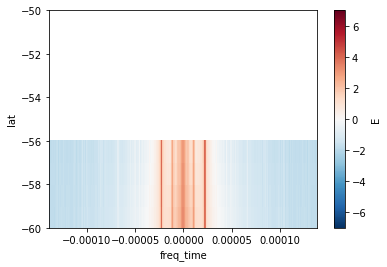

In [53]:
#np.log10(ds_zavg.sel(lat=slice(-60.,-50.)).E).plot()
#plt.xscale('log')

In [3]:
filenames = sorted(glob(E_dir+'E_zavg_f*.nc'))
#%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
#%time ds = ds.chunk({'i': 1, 'j': 2160})
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
print(ds)

CPU times: user 128 ms, sys: 24 ms, total: 152 ms
Wall time: 1.06 s
<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 959, lat: 120)
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001387 -0.0001385 -0.0001382 ...
Dimensions without coordinates: face
Data variables:
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 959), chunksize=(1, 120, 959)>
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>


In [4]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
print(E)

<xarray.DataArray (lat: 120, freq_time: 959)>
dask.array<shape=(120, 959), dtype=float64, chunksize=(120, 959)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001387 -0.0001385 -0.0001382 ...


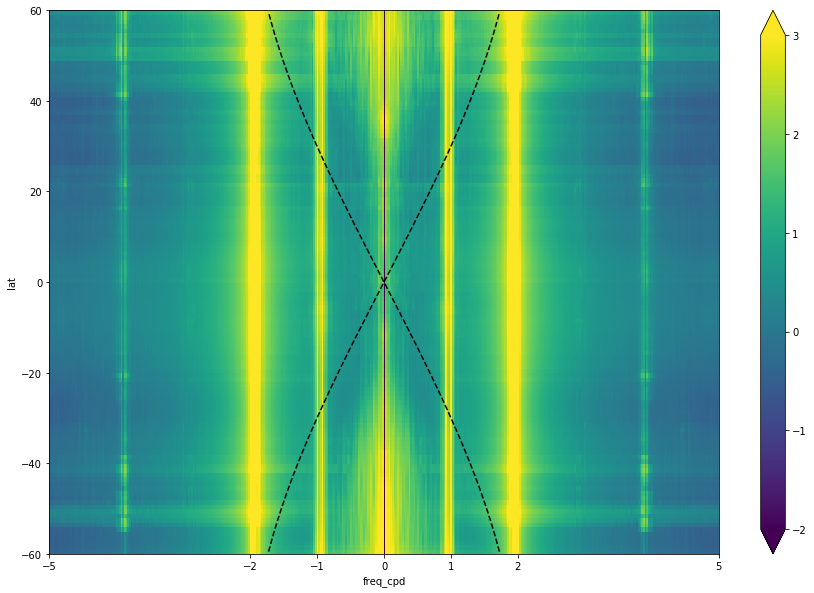

In [25]:
#ds.E.isel(face=2).plot()
plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.)
np.log10(E).plot.pcolormesh(ax=ax, vmin=-2., vmax=3., x='freq_cpd', y='lat')
ax.set_xticks(list(ax.get_xticks()) + [-2., -1., 1., 2.])
ax.set_xlim(-12., 12.)
ax.set_xlim(-5., 5.)
#ax.set_xticks(list(ax.get_xticks()) + extraticks)

f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))

ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')


#, x=E.freq_time*86400)

### load E

In [6]:
file_E = scratch+'/mit_spec/E.nc'
#Enc = xr.open_dataset(file_E, chunks={'freq_time': 1})
Enc = xr.open_dataset(file_E, chunks={'i': 1})
Enc.rename({'eta_power_spectrum (??)': 'E_eta'}, inplace=True) # tmp
#Enc.drop(['XG','YG']) # tmp, should be dropped while creating spectrum
Enc = Enc.persist()
print(Enc)

<xarray.Dataset>
Dimensions:            (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k                  (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k_u                (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_l                (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_p1               (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 

In [7]:
print(Enc['YC'])
dlat=1.
#v1b = {'min': dlat*np.ceil(grid.YC.min().values/dlat),'max': dlat*np.floor(grid.YC.max().values/dlat), 'd': dlat}
#lat_bins = np.arange(dlat*np.ceil(Enc.YC.min().values/dlat),dlat*np.floor(Enc.YC.max().values/dlat),dlat)
lat_bins = np.arange(-60.,60.,dlat)
lat_center = (lat_bins[:-1]+lat_bins[1:])*.5

<xarray.DataArray 'YC' (i: 4320, j: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 4320)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    coordinate:     YC XC


In [21]:
#Enc = xr.merge([Enc, grid])
#print(Enc)

In [8]:
# look at one frequency first
%time Ef0 = Enc.isel(freq_time=0, drop=False).groupby_bins('YC', lat_bins).mean()

CPU times: user 43.8 s, sys: 1.59 s, total: 45.4 s
Wall time: 53.6 s


In [9]:
Ef = Ef0.assign_coords(lat=xr.DataArray(lat_center,dims=['YC_bins'])).drop('YC_bins')
print(Ef)

<xarray.Dataset>
Dimensions:  (YC_bins: 69)
Coordinates:
    lat      (YC_bins) float64 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 ...
Dimensions without coordinates: YC_bins
Data variables:
    E_eta    (YC_bins) float64 dask.array<shape=(69,), chunksize=(1,)>


In [10]:
%time Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%0, mode='w')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 187.41 MB detected in task graph: 
  ("('concatenate-ba831207edf0e9e9ab900a73aef020d1', ... 3860>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))

KeyboardInterrupt



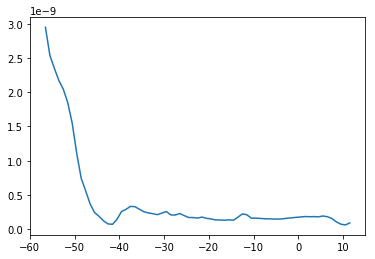

In [21]:
plt.plot(lat_center, Ef['eta_power_spectrum (??)'].values)

In [ ]:

Eb = xr.concat([Enc['E_eta'].isel(freq_time=i).groupby_bins('YC', lat_bins).mean().expand_dims(dim='f', axis=1) \
    for i in range(len(Enc.freq_time))], dim='f')
#len(Enc.freq_time)

# should maybe store data with an explicit for loop?
# this is not performant but should work

print(Eb)
#print(Eb.values)

In [ ]:
for i in range(len(Enc['freq_time'])):
    Ef = Enc['E_eta'].isel(freq_time=i).groupby_bins('YC', lat_bins).mean()
    Ef = Ef.expand_dims(dim='f', axis=1)
    Ef = Ef.assign_coords(lat=xr.DataArray(lat_center,dims=['YC_bins'])).drop('YC_bins')    
    Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%i, mode='w')
    print(i)

### with dask objects

In [7]:
print(Enc)

<xarray.Dataset>
Dimensions:            (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * j_g                (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k                  (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k_u                (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_l                (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * k_p1               (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 

In [8]:
lat = Enc['YC']
f = Enc['freq_time']

dlat=1.

v1b = {'min': -60.,'max': 60., 'd': dlat}
v2b = {'min': f.min().values, 'max': f.max().values, 'd': f[1].values-f[0].values}

i1max = np.int(np.rint((v1b['max']-v1b['min'])/v1b['d']))+1
i2max = np.int(np.rint((v2b['max']-v2b['min'])/v2b['d']))+1

def fmap(v1,v2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-v1b['min'])/v1b['d'])+1,0)
        i1 = np.minimum(i1,i1max)
        #
        i2 = np.maximum(np.rint((v2-v2b['min'])/v2b['d'])+1,0)
        i2 = np.minimum(i2,i2max)
        return i1+i2*(i1max+1)

#def imap(i)
#    return lat, f

def printb(v,label):
    print('%s: min %e, max %e, step %e '%(label, v['min'], v['max'], v['d']) )

printb(v1b, 'lat')
printb(v2b, 'freq')

print(fmap(-40., 1e-3))


lat: min -6.000000e+01, max 6.000000e+01, step 1.000000e+00 
freq: min -1.388889e-04, max 1.383102e-04, step 5.787037e-07 
58581.0


In [20]:
lat2 = lat + f*0.
f2 = lat*0. + f
# reset land data
lat2 = (lat2 + 0.*Enc['E_eta']).fillna(-100.)
#
#lat2, f2 = xr.broadcast(lat,f) # f2 is not a dask array chunked along i
#f2 = f2.chunk({'i':1})
#
f2 = f2.persist()


print(lat2)
print(f2)

<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 5.787e-07
    face               int64 1
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 

In [21]:
# apply get_index to v1 and v2 arrays
i = dask.array.map_blocks(fmap, lat2.data, f2.data, dtype='float')
print(i)

dask.array<fmap, shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>


In [29]:
dA = Enc['rA'] + 0.*f2
EdA = Enc['E_eta'].fillna(0.)*dA
print(dA)
print(EdA)

<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 5.787e-07
    face               int64 1
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(1, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
<xarray.DataArray (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(1, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 

In [30]:
# compute histogram of linear indices
h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.), \
                                weights=EdA.data)
hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.), \
                                weights=dA.data)

In [31]:
# normalize and reshape
H = h.compute()
Hnorm = hnorm.compute()
H = H/Hnorm
H = H.reshape((i1max+1,i2max+1), order='F')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [24]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


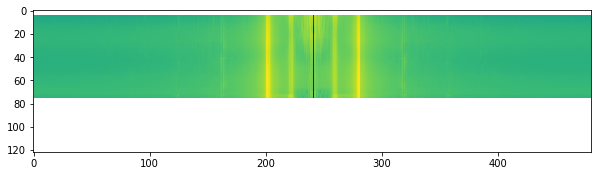

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(H))

### with dask delayed

In [18]:
from dask import compute, delayed

In [19]:
def process(lE, i):    
    Ef = lE['eta_power_spectrum (??)'].groupby_bins('YC', lat_bins).mean()
    Ef.to_netcdf(scratch+'/mit_spec/E_%03d.nc'%i)
    return Ef.mean()

I = range(len(Enc['freq_time']))
values = [delayed(process)(Enc.isel(freq_time=i),i) for i in I]

In [ ]:
%time results = compute(*values, get=client.get)
# Large object of size 74.80 MB detected in task graph

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 74.80 MB detected in task graph: 
  ([[["('getitem-57f7f9562bff9d4baa84364946dcfc7e',  ... (), None, None)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [ ]:
lat = Enc.YC + 0.*Enc.freq_time
f = Enc.YC*0. + Enc.freq_time
print(lat)
print(f)

In [ ]:
i = fmap(lat, f)
print(i)

In [ ]:
i.isel(i=slice(0,100), j=slice(0,100), freq_time=0).plot()

In [ ]:
grid = xr.open_dataset('/home1/scratch/aponte/mit_grid.nc')
grid = grid.isel(face=face)
print(grid)
%time print(grid['YC'].mean().values)

In [ ]:
grid = xr.open_dataset('/home1/scratch/aponte/mit_grid.nc', chunks={'i':10, 'j':432})
grid = grid.isel(face=face)
print(grid)
%time print(grid['YC'].mean().values)

---

In [15]:
client.restart()

Client Scheduler: tcp://10.148.0.220:8786 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 31 Cores: 434 Memory: 3100.00 GB


In [14]:
print(datawork)

/home1/datawork/aponte


In [ ]:

data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
